<h1 style="text-align:center;">Modelling for S&P 500</h1>

### Model Training 

In [3]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
import numpy as np
import time

# Load the data
df = pd.read_csv('/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/Datasets/dataframe_cleaned.csv')

#Time-Series set the Data
import time
if isinstance(df.index, pd.DatetimeIndex):
    print("Time Series has been set")
else:
    print("Time Series has not been set yet")
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)
    time.sleep(3)
    print("It has been done now!")

#Split the data into training and testing
size = int(len(df)*0.7)
df, df_test = df.iloc[:size], df.iloc[size:]

#Normalised Prices
df_norm = df/df.iloc[0]*100 #Create a new variable incase we want to visualise/test/forecast with the original data
df_norm_test = df_test/df.iloc[0]*100

#Log Returns 
df_log = np.log(df / df.shift(1))
df_log_test = np.log(df_test / df_test.shift(1))

#Creating LLR Test (defining the function)
from scipy.stats import chi2
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

Time Series has not been set yet
It has been done now!


### Testing for Stationarity

Text(0.5, 1.0, 'S&P 500 Prices')

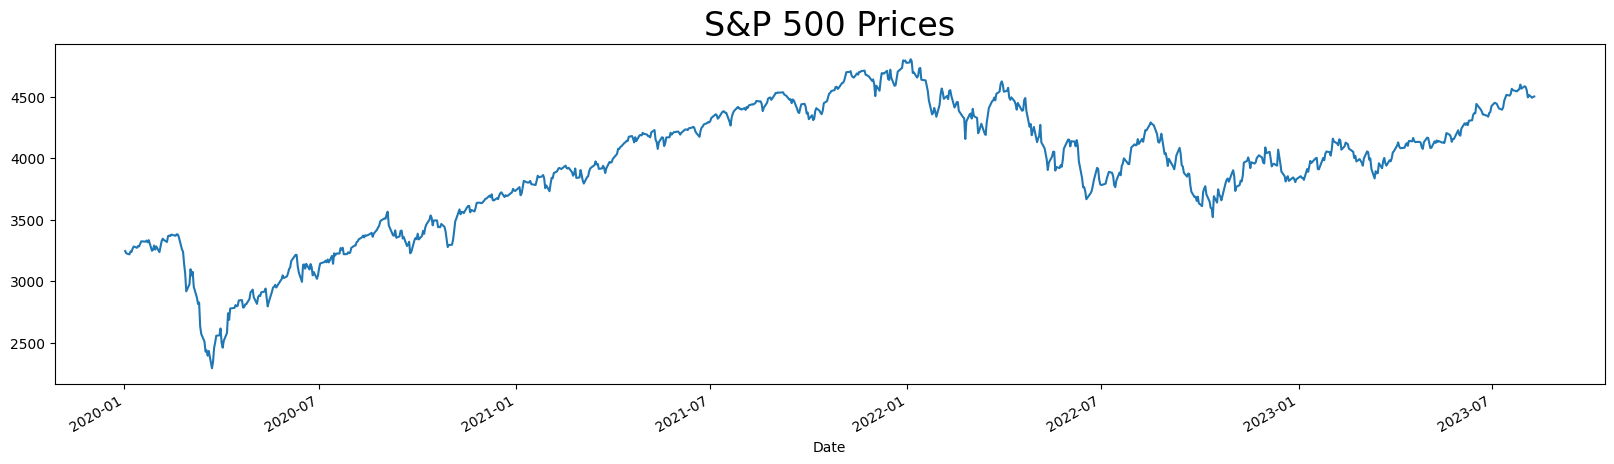

In [4]:
df.SPX.plot(figsize=(20,5))
plt.title("S&P 500 Prices", size=24) 

In [5]:
#Dickey-Fuller Test
import statsmodels.tsa.stattools as sts
adf_result = sts.adfuller(df.SPX)

adf_pvalue = adf_result[1]

print(adf_result)
print(f'p-value from ADF test = {adf_pvalue}')

(-1.4486541777836797, 0.5587414535462336, 1, 905, {'1%': -3.437596348122793, '5%': -2.86473892523805, '10%': -2.5684733191905007}, 9245.540200441512)
p-value from ADF test = 0.5587414535462336


From the ADF test, we find that the price of the S&P 500 is non-stationary, so we should difference (to the order of integration 1 [I=1]) to see if this makes our data stationary.

In [6]:
#Diferencing our prices
df['SPX_d1'] = df['SPX'].diff()

In [7]:
df['SPX_d1'] = df.SPX.diff(1)
df= df.dropna()
df.head()


,SPX,NDAQ,AAPL,MSFT,NFLX,NVDA,SPX_d1
Date,,,,,,,
2020-01-03,3226.360107,33.176522,71.941343,151.127748,326.779999,5.852962,-18.309815
2020-01-06,3217.550049,33.427723,71.127858,149.944070,323.119995,5.783753,-8.810058
2020-01-07,3241.860107,33.492839,72.592594,152.082331,336.470001,5.930140,24.310058
2020-01-08,3238.590088,33.030765,71.943766,151.710031,331.489990,5.968977,-3.270019
2020-01-09,3266.030029,32.956335,74.384158,154.487843,342.000000,6.070800,27.439941


In [8]:
SPX_d1 = df.dropna(subset=["SPX_d1"])
print(df['SPX_d1'].head())

Date
2020-01-03   -18.309815
2020-01-06    -8.810058
2020-01-07    24.310058
2020-01-08    -3.270019
2020-01-09    27.439941
Name: SPX_d1, dtype: float64


Text(0.5, 1.0, 'S&P 500 Prices (First Difference)')

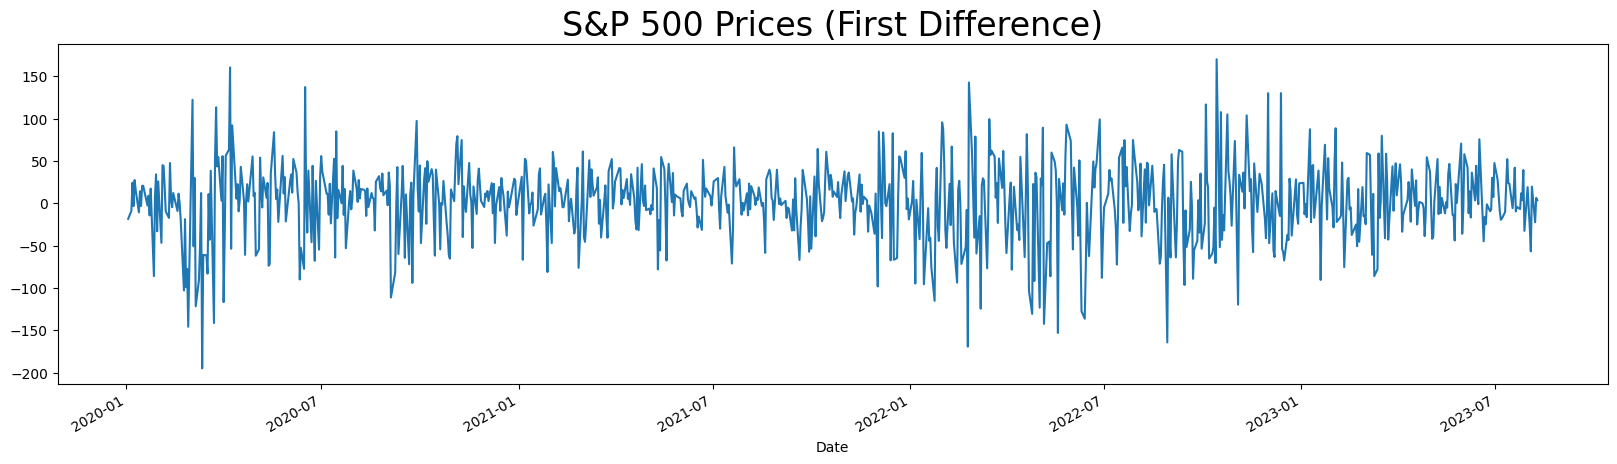

In [9]:
df['SPX_d1'].plot(figsize=(20,5))
plt.title("S&P 500 Prices (First Difference)", size=24) 

Here, we see that when the S&P 500 has been differenced once, our plot already look stationary. To confirm, we should run the ADF test again.

In [10]:
#Dickey-Fuller Test
adf_result = sts.adfuller(df["SPX_d1"].dropna()) 
adf_pvalue = adf_result[1]

print(adf_result)
print(f'p-value from ADF test = {adf_pvalue}')

(-28.366021661124638, 0.0, 0, 905, {'1%': -3.437596348122793, '5%': -2.86473892523805, '10%': -2.5684733191905007}, 9235.196934895024)
p-value from ADF test = 0.0


We see that the p-value < 0.05, so (via. the ADF test) we find that prices are now stationary (in first difference form).

### PACF and ACF plots (to find optimal number of lags for AR and MA)

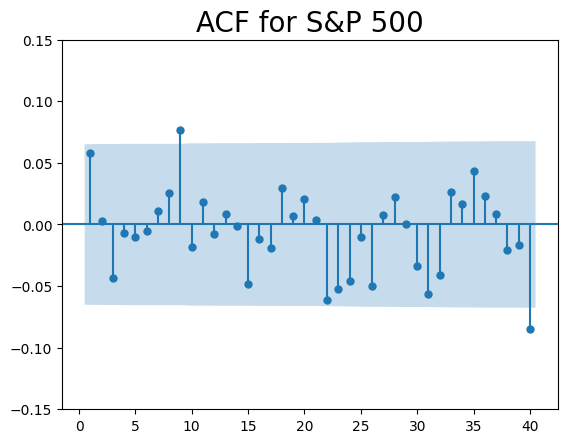

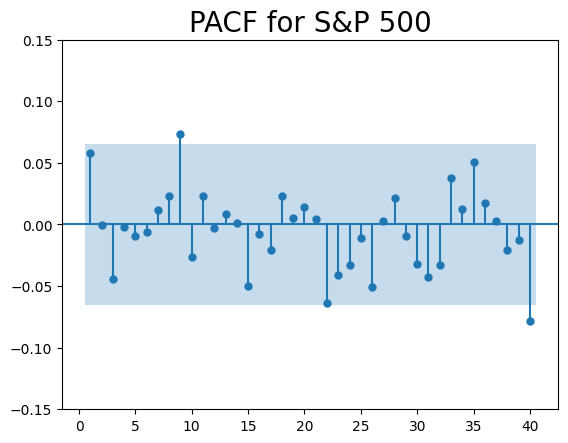

In [11]:
import matplotlib.pyplot as plt  
import statsmodels.graphics.tsaplots as sgt

#Plot the ACF for S&P 500
sgt.plot_acf(df['SPX_d1'], zero=False, lags=40)
plt.title("ACF for S&P 500", size=20)
plt.gca().set_ylim(-0.15, 0.15)
plt.show()

#Plot the PACF for S&P 500
sgt.plot_pacf(df['SPX_d1'], zero=False, lags=40)
plt.title("PACF for S&P 500", size=20)
plt.gca().set_ylim(-0.15, 0.15)
plt.show()

### Fitting the Model

In [12]:
import pmdarima as pm
# Define the maximum number of lags to consider
max_lags = 10

# Function to find the best ARIMA order using different information criteria
def find_best_arima_order(series, max_lags, criterion):
    model = pm.auto_arima(
        series,
        start_p=0, start_q=0,
        max_p=max_lags, max_q=max_lags,
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        information_criterion=criterion
    )
    return model.order

# Find the best ARIMA order for spx using AIC, BIC, and HQIC
spx_orders = {
    'AIC': find_best_arima_order(df['SPX'], max_lags, 'aic'),
    'BIC': find_best_arima_order(df['SPX'], max_lags, 'bic'),
    'HQIC': find_best_arima_order(df['SPX'], max_lags, 'hqic')
}

# Print the selected ARIMA orders for yt
for criterion, order in spx_orders.items():
    print(f'Selected ARIMA order for spx using {criterion}: {order}')

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warning

Selected ARIMA order for spx using AIC: (0, 1, 0)
Selected ARIMA order for spx using BIC: (0, 1, 0)
Selected ARIMA order for spx using HQIC: (0, 1, 0)


/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
model_spx_010 = ARIMA(df["SPX"], order=(0,1,0))
results_model_spx_010 = model_spx_010.fit()
print(results_model_spx_010.summary())

                               SARIMAX Results                                
Dep. Variable:                    SPX   No. Observations:                  906
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4721.370
Date:                Sun, 23 Mar 2025   AIC                           9444.740
Time:                        00:51:37   BIC                           9449.548
Sample:                             0   HQIC                          9446.576
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1990.3999     70.436     28.258      0.000    1852.347    2128.453
Ljung-Box (L1) (Q):                   3.01   Jarque-Bera (JB):               119.75
Prob(Q):                              0.08   Pr

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


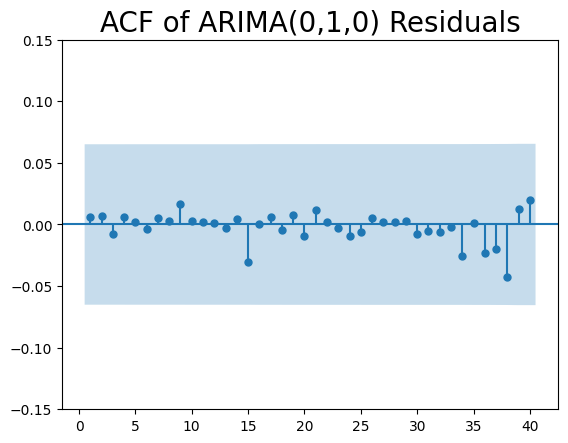

In [14]:
model_spx_010_res = results_model_spx_010.resid 

sgt.plot_acf(model_spx_010_res, zero=False, lags=40)
plt.title("ACF of ARIMA(0,1,0) Residuals", size=20)
plt.gca().set_ylim(-0.15, 0.15)
plt.show()

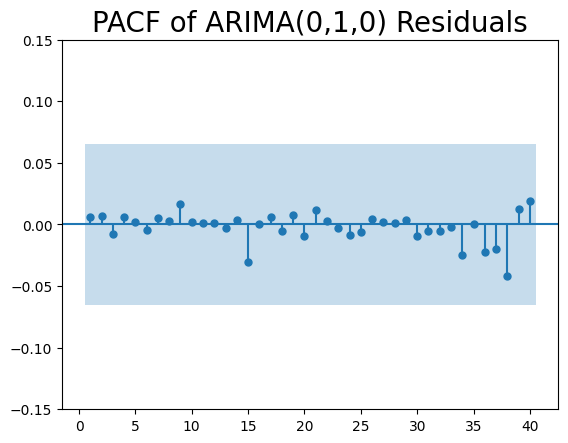

In [15]:
model_spx_010_res = results_model_spx_010.resid 

sgt.plot_pacf(model_spx_010_res, zero=False, lags=40)
plt.title("PACF of ARIMA(0,1,0) Residuals", size=20)
plt.gca().set_ylim(-0.15, 0.15)
plt.show()

In [16]:
exog_vars = df[['NDAQ']]
aligned_data = df['SPX_d1'].to_frame().join(exog_vars, how='inner')

endog = aligned_data['SPX_d1']  
exog = aligned_data['NDAQ']

print("Shape of SPX_d1:", df['SPX_d1'].shape)
print("Shape of Exogenous Variables:", exog.shape)

Shape of SPX_d1: (906,)
Shape of Exogenous Variables: (906,)


In [17]:
import pmdarima as pm

# Define the maximum number of lags to consider
max_lags = 10

# Function to find the best ARIMA order using different information criteria with exogenous variables
def find_best_arima_order(series, exog_vars, max_lags, criterion):
    model = pm.auto_arima(
        series,
        exogenous=exog_vars,
        start_p=0, start_q=0,
        max_p=max_lags, max_q=max_lags,
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        information_criterion=criterion
    )
    return model.order

# Assuming df contains your time series data and exog_vars contains exogenous variables
spx_orders = {
    'AIC': find_best_arima_order(df['SPX'], exog_vars, max_lags, 'aic'),
    'BIC': find_best_arima_order(df['SPX'], exog_vars, max_lags, 'bic'),
    'HQIC': find_best_arima_order(df['SPX'], exog_vars, max_lags, 'hqic')
}

# Print the selected ARIMA orders for SPX
for criterion, order in spx_orders.items():
    print(f'Selected ARIMAX order for SPX using {criterion}: {order}')


/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warning

Selected ARIMAX order for SPX using AIC: (0, 1, 0)
Selected ARIMAX order for SPX using BIC: (0, 1, 0)
Selected ARIMAX order for SPX using HQIC: (0, 1, 0)


### Forecasting

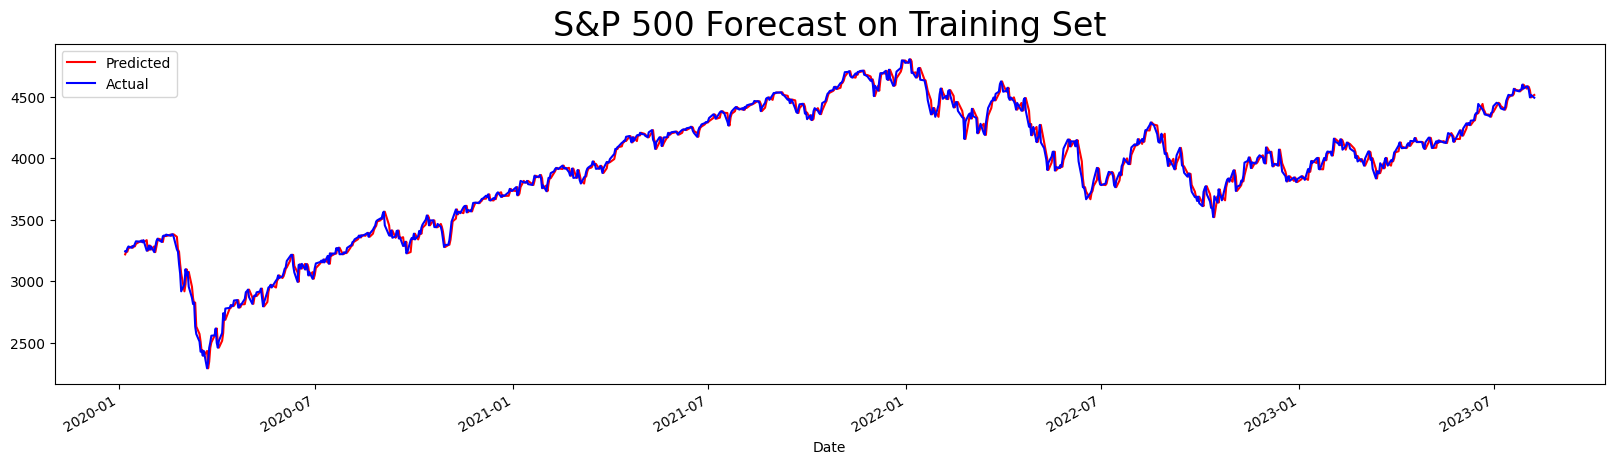

In [18]:
start_date = "2020-01-07"
end_date = "2023-08-07"

df_forecast = results_model_spx_010.predict(start=start_date, end=end_date)

df_forecast[start_date:end_date].plot(figsize=(20, 5), color="red", label='Predicted')
df['SPX'][start_date:end_date].plot(color="blue", label='Actual')
plt.title("S&P 500 Forecast on Training Set", size=24)
plt.legend()
plt.show()

In [19]:
print(df_test.SPX.head())
print(df_test.SPX.tail())

#Find that the starting date of the testing set is 2023-08-10 and ending date of testing set is 2025-02-28

Date
2023-08-10    4487.160156
2023-08-11    4450.689941
2023-08-14    4458.129883
2023-08-15    4478.870117
2023-08-16    4433.790039
Name: SPX, dtype: float64
Date
2025-02-24    6026.689941
2025-02-25    5982.729980
2025-02-26    5970.870117
2025-02-27    5981.879883
2025-02-28    5856.740234
Name: SPX, dtype: float64


/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


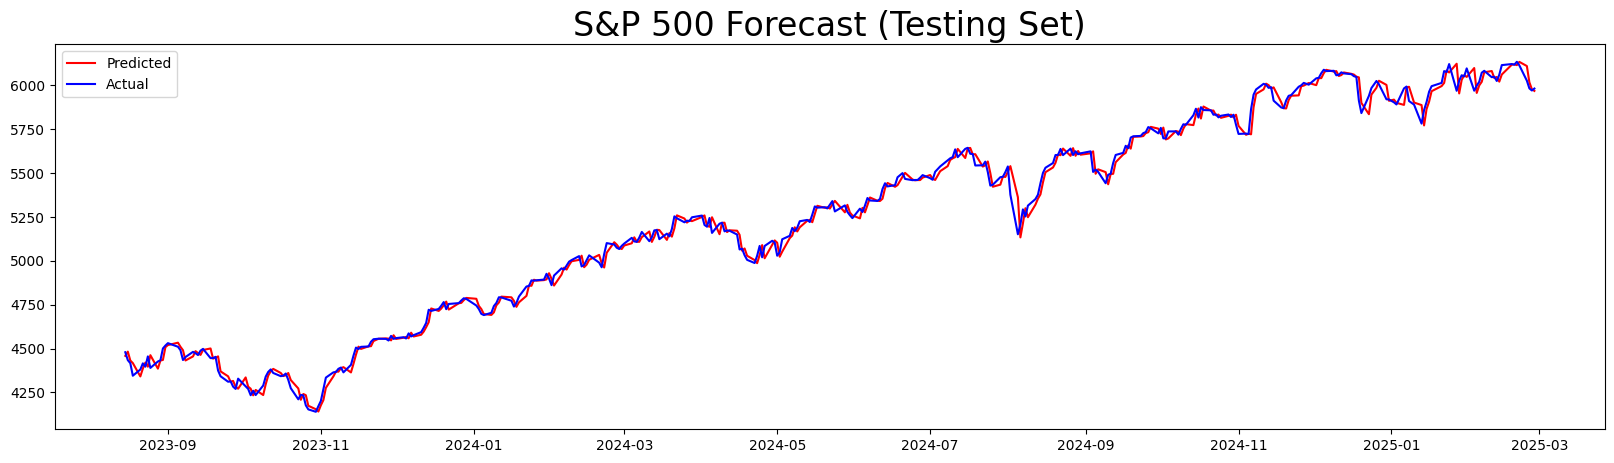

In [20]:
# Define test start and end dates
test_start_date = "2023-08-15"
test_end_date = "2025-02-27"

# Convert start date to a timestamp
test_start_date_ts = pd.Timestamp(test_start_date)

# Fit ARIMA model
test_model_spx_101 = ARIMA(df_test.SPX[1:], order=(1,0,1))
test_results_model_spx_101  = test_model_spx_101.fit()

# Generate predictions at price level
pred_test_model_spx_101 = test_results_model_spx_101 .predict(start=test_start_date, end=test_end_date, typ='levels')

# Find the last actual value before prediction starts
last_actual_value = df_test['SPX'].loc[test_start_date_ts - pd.Timedelta(days=1)]

# Fix the first predicted value to align with actual price
pred_test_model_spx_101.iloc[0] = last_actual_value

# Plot results
plt.figure(figsize=(20, 5))
plt.plot(pred_test_model_spx_101, color="red", label='Predicted')
plt.plot(df_test.SPX[test_start_date:test_end_date], color="blue", label='Actual')
plt.title("S&P 500 Forecast (Testing Set)", size=24)
plt.legend()
plt.show()


### Predicting S&P 500 Prices

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python

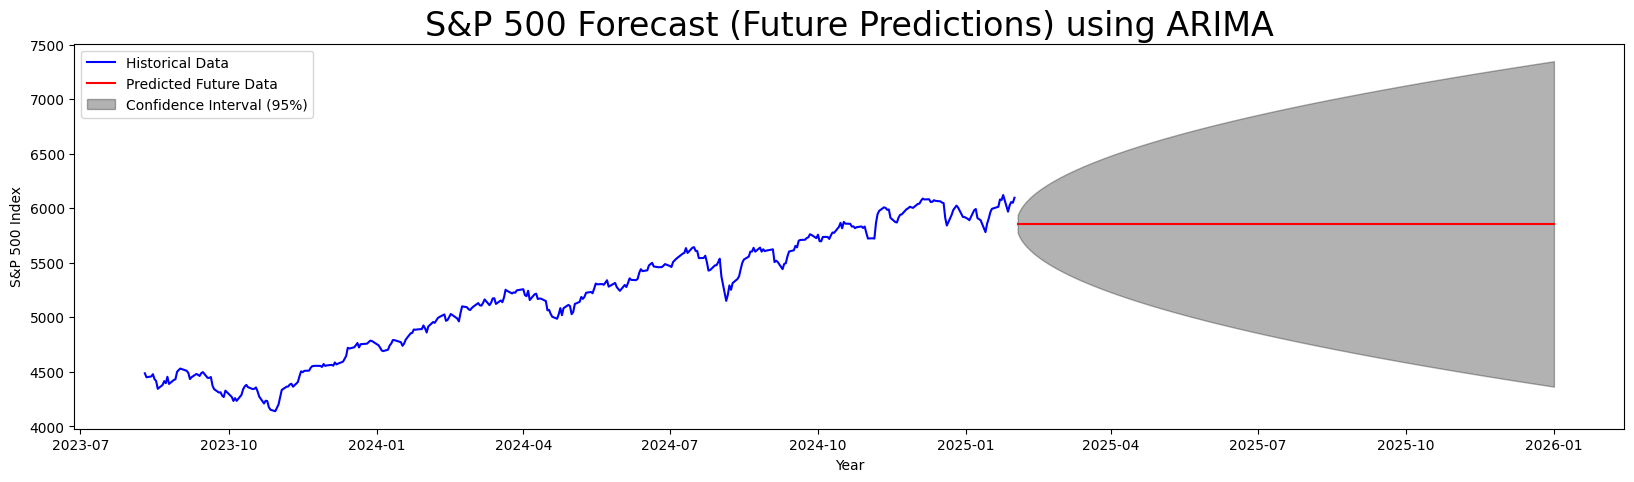

In [21]:
#Using ARIMA Model#
#Prediction date range
predict_start_date = "2025-02-2"
predict_end_date = "2026-01-01"
predict_end_date_ts = pd.Timestamp(predict_end_date)
predict_start_date_ts = pd.Timestamp(predict_start_date)

#Calculate the number of steps to forecast
num_steps = (predict_end_date_ts - predict_start_date_ts).days + 1

#Fit the ARIMA model on the entire dataset
model_spx_010 = ARIMA(df_test['SPX'], order=(0,1,0))
results_model_spx_010 = model_spx_010.fit()

#Generate predictions for the future dates (beyond the dataset)
forecast = results_model_spx_010.get_forecast(steps=num_steps)
future_predictions = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

#Create a date range for the future predictions
future_dates = pd.date_range(start=predict_start_date, end=predict_end_date, freq='D')

#Align the predictions with the future dates
future_predictions.index = future_dates

#Plot the results
plt.figure(figsize=(20, 5))
plt.plot(df_test.SPX[:predict_start_date], color="blue", label='Historical Data')
plt.plot(future_predictions, color="red", label='Predicted Future Data')
plt.fill_between(future_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='black', alpha=0.3, label='Confidence Interval (95%)')

plt.title("S&P 500 Forecast (Future Predictions) using ARIMA", size=24)
plt.xlabel("Year")
plt.ylabel("S&P 500 Index")
plt.legend()
plt.show()

In [34]:
#Setting up exogeneous variables for future predictions
exog_vars = df[['NDAQ']]
aligned_data = df['SPX'].to_frame().join(exog_vars, how='inner')

endog = aligned_data['SPX']  
exog = aligned_data['NDAQ']

print("Shape of SPX:", df['SPX'].shape)
print("Shape of Exogenous Variables:", exog.shape)

Shape of SPX: (906,)
Shape of Exogenous Variables: (906,)


/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.68803D+00    |proj g|=  1.13714D-03
  ys=-9.960E+00  -gs= 9.423E-01 BFGS update SKIPPED

At iterate    5    f=  4.78671D+00    |proj g|=  4.16165D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     22      2     1     0   4.162D-06   4.787D+00
  F =   4.7867114454390967     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


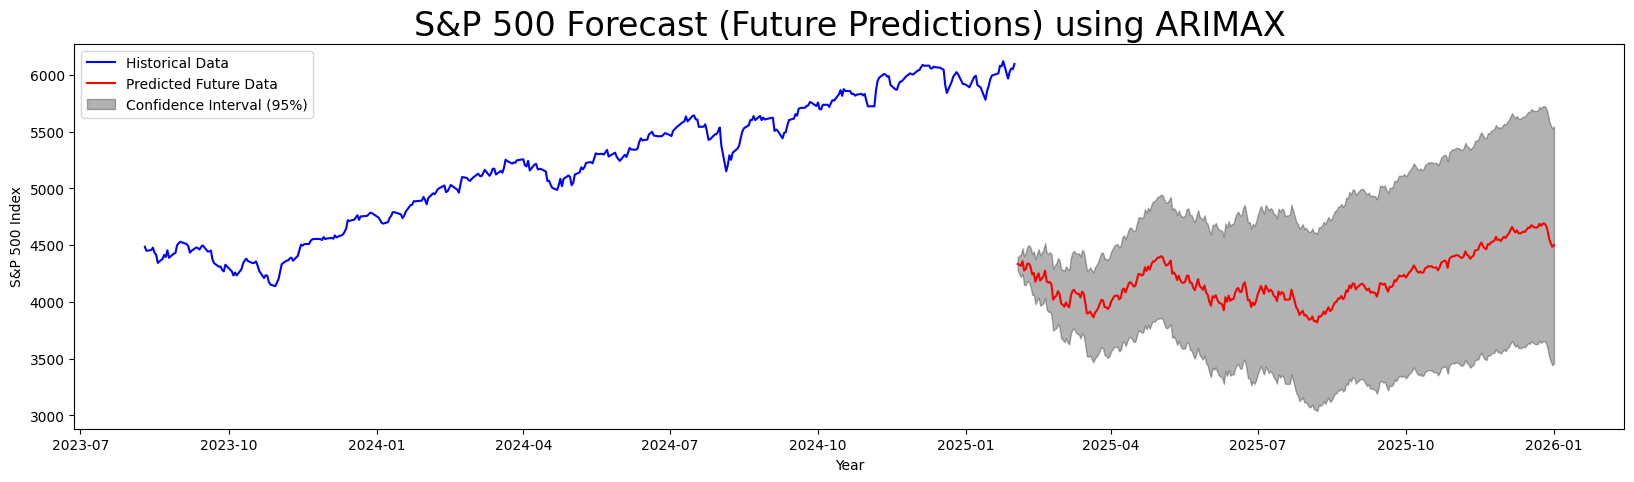

In [23]:
#Using SARIMA Model#
#Dates are same as above#
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Fit the ARIMAX model on the entire dataset
model_spx_010_s = SARIMAX(df['SPX'], exog=exog_vars, order=(0,1,0))
results_model_spx_010_s = model_spx_010_s.fit()

# Calculate the number of steps to forecast
num_steps = (predict_end_date_ts - predict_start_date_ts).days + 1

# Generate future exogenous values (Ensure num_steps rows exist)
future_exog = exog_vars.iloc[-num_steps:].copy() 
if future_exog.shape[0] < num_steps:
    last_exog = exog_vars.iloc[-1].values.reshape(1, -1) 
    future_exog = pd.DataFrame(
        np.tile(last_exog, (num_steps, 1)), 
        columns=exog_vars.columns
    )

# Generate predictions for the future dates (beyond the dataset)
forecast = results_model_spx_010_s.get_forecast(steps=num_steps, exog=future_exog)
future_predictions = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a date range for the future predictions
future_dates = pd.date_range(start=predict_start_date, periods=num_steps)

# Align the predictions with the future dates
future_predictions.index = future_dates

# Plot the results
plt.figure(figsize=(20, 5))
plt.plot(df_test.SPX[:predict_start_date], color="blue", label='Historical Data')
plt.plot(future_predictions, color="red", label='Predicted Future Data')
plt.fill_between(future_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], 
                 color='black', alpha=0.3, label='Confidence Interval (95%)')
plt.title("S&P 500 Forecast (Future Predictions) using ARIMAX", size=24)
plt.xlabel("Year")
plt.ylabel("S&P 500 Index")
plt.legend()
plt.show()

In [36]:
#Using ARIMAX Model#
#Setting up exogeneous variables for future predictions
exog_vars = df[['NDAQ']]
aligned_data = df['SPX'].to_frame().join(exog_vars, how='inner')

endog = aligned_data['SPX']  
exog = aligned_data['NDAQ']

print("Shape of SPX:", df['SPX'].shape)
print("Shape of Exogenous Variables:", exog.shape)

from statsmodels.tsa.statespace.sarimax import SARIMAX

#Prediction date range
predict_start_date = "2025-02-2"
predict_end_date = "2026-01-01"
predict_end_date_ts = pd.Timestamp(predict_end_date)
predict_start_date_ts = pd.Timestamp(predict_start_date)

#Calculate the number of steps to forecast
num_steps = (predict_end_date_ts - predict_start_date_ts).days + 1

#Fit the ARIMA model on the entire dataset
model_spx_010_s = SARIMAX(df['SPX'], exog=exog_vars, order=(0,1,0))
results_model_spx_010_s = model_spx_010_s.fit()

#Generate predictions for the future dates (beyond the dataset)
forecast = results_model_spx_010_s.get_forecast(steps=num_steps)
future_predictions = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

#Create a date range for the future predictions
future_dates = pd.date_range(start=predict_start_date, end=predict_end_date, freq='D')

#Align the predictions with the future dates
future_predictions.index = future_dates

#Plot the results
plt.figure(figsize=(20, 5))
plt.plot(df_test.SPX[:predict_start_date], color="blue", label='Historical Data')
plt.plot(future_predictions, color="red", label='Predicted Future Data')
plt.fill_between(future_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='black', alpha=0.3, label='Confidence Interval (95%)')

plt.title("S&P 500 Forecast (Future Predictions) using ARIMA", size=24)
plt.xlabel("Year")
plt.ylabel("S&P 500 Index")
plt.legend()
plt.show()

Shape of SPX: (906,)
Shape of Exogenous Variables: (906,)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82434D+00    |proj g|=  9.92087D-04

At iterate    5    f=  4.92302D+00    |proj g|=  2.32676D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     20      1     0     0   2.327D-06   4.923D+00
  F =   4.9230215325616031     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

Shape of SPX: (390,)
Shape of Exogenous Variables: (390,)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.49690D+00    |proj g|=  1.35889D-03
  ys=-5.972E+00  -gs= 9.048E-01 BFGS update SKIPPED

At iterate    5    f=  5.02019D+00    |proj g|=  3.05445D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     23      2     1     0   3.054D-07   5.020D+00
  F =   5.0201886805354290     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/

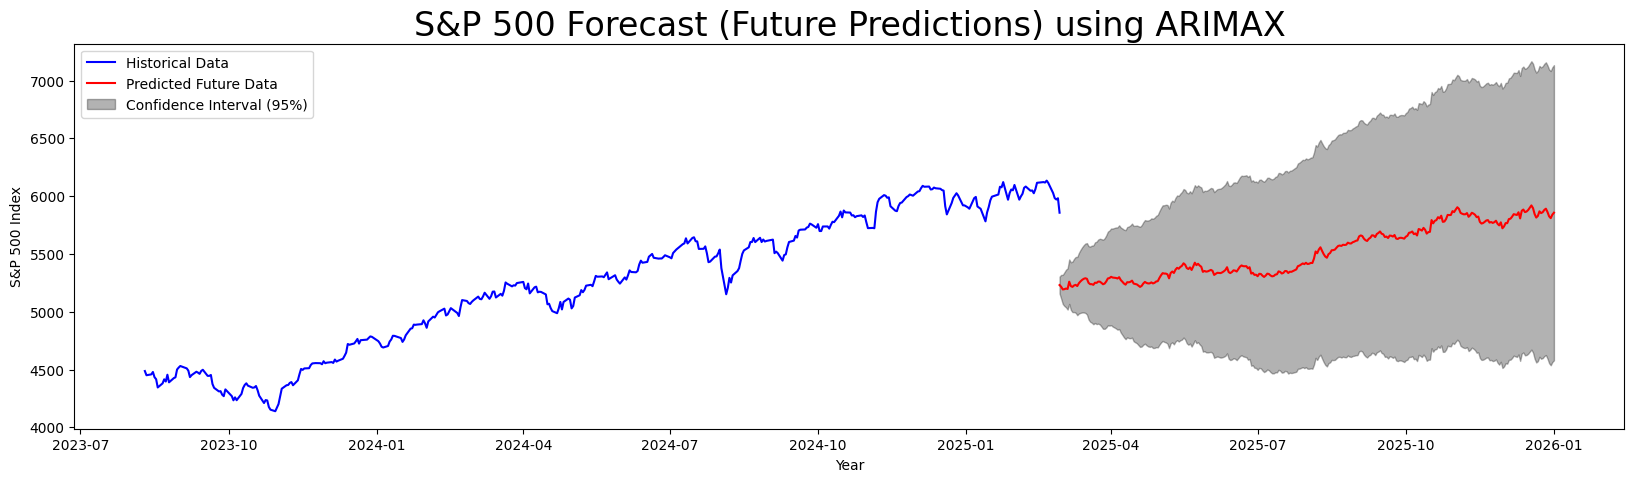

In [39]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Define the exogenous variable
exog_vars = df_test[['NDAQ']]

# Align the indices of df_test['SPX'] and exog_vars
aligned_data = df_test['SPX'].to_frame().join(exog_vars, how='inner')

# Extract the aligned endog and exog
endog = aligned_data['SPX']  # Dependent variable (SPX)
exog = aligned_data['NDAQ']  # Exogenous variable (NDAQ)

# Print the shapes of the aligned endog and exog
print("Shape of SPX:", endog.shape)
print("Shape of Exogenous Variables:", exog.shape)

# Define the prediction date range
predict_start_date = "2025-02-28"
predict_end_date = "2026-01-01"

# Convert the end date to a timestamp to calculate the number of steps
predict_end_date_ts = pd.Timestamp(predict_end_date)
predict_start_date_ts = pd.Timestamp(predict_start_date)

# Calculate the number of steps to forecast
num_steps = (predict_end_date_ts - predict_start_date_ts).days + 1

# Fit the SARIMAX model on the aligned dataset
model_spx_010_s = SARIMAX(endog, exog=exog, order=(0, 1, 0))
results_model_spx_010_s = model_spx_010_s.fit()

# Generate future exogenous values (Ensure num_steps rows exist)
future_exog = exog.iloc[-num_steps:].copy()
if future_exog.shape[0] < num_steps:
    last_exog = exog.iloc[-1].values.reshape(1, -1)
    future_exog = pd.DataFrame(
        np.tile(last_exog, (num_steps, 1)),
        columns=exog_vars.columns
    )

# Generate predictions for the future dates (beyond the dataset)
forecast = results_model_spx_010_s.get_forecast(steps=num_steps, exog=future_exog)
future_predictions = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a date range for the future predictions
future_dates = pd.date_range(start=predict_start_date, periods=num_steps)

# Align the predictions with the future dates
future_predictions.index = future_dates

# Plot the results
plt.figure(figsize=(20, 5))
plt.plot(df_test['SPX'][:predict_start_date], color="blue", label='Historical Data')
plt.plot(future_predictions, color="red", label='Predicted Future Data')
plt.fill_between(future_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], 
                 color='black', alpha=0.3, label='Confidence Interval (95%)')
plt.title("S&P 500 Forecast (Future Predictions) using ARIMAX", size=24)
plt.xlabel("Year")
plt.ylabel("S&P 500 Index")
plt.legend()
plt.show()

Shape of SPX: (390,)
Shape of Exogenous Variables: (390,)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.49690D+00    |proj g|=  1.35889D-03
  ys=-5.972E+00  -gs= 9.048E-01 BFGS update SKIPPED

At iterate    5    f=  5.02019D+00    |proj g|=  3.05445D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     23      2     1     0   3.054D-07   5.020D+00
  F =   5.0201886805354290     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/

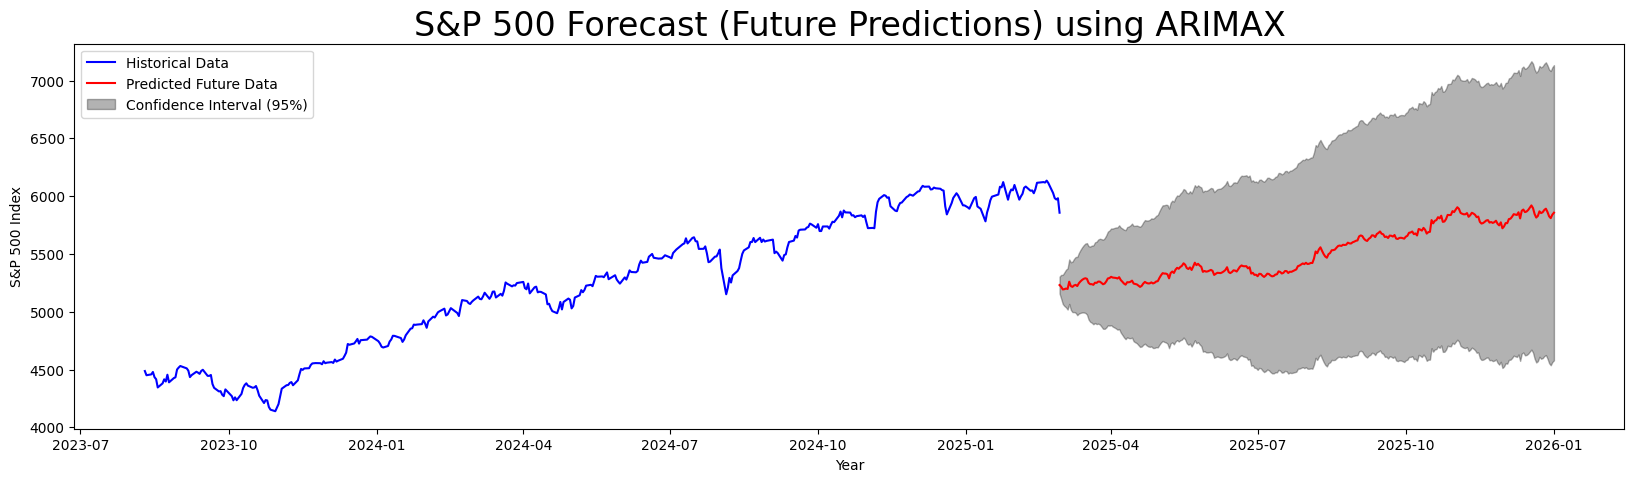

In [40]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Define the exogenous variable
exog_vars = df_test[['NDAQ']]

# Align the indices of df_test['SPX'] and exog_vars
aligned_data = df_test['SPX'].to_frame().join(exog_vars, how='inner')

# Extract the aligned endog and exog
endog = aligned_data['SPX']  # Dependent variable (SPX)
exog = aligned_data['NDAQ']  # Exogenous variable (NDAQ)

# Print the shapes of the aligned endog and exog
print("Shape of SPX:", endog.shape)
print("Shape of Exogenous Variables:", exog.shape)

# Define the prediction date range
predict_start_date = "2025-02-28"
predict_end_date = "2026-01-01"

# Convert the end date to a timestamp to calculate the number of steps
predict_end_date_ts = pd.Timestamp(predict_end_date)
predict_start_date_ts = pd.Timestamp(predict_start_date)

# Calculate the number of steps to forecast
num_steps = (predict_end_date_ts - predict_start_date_ts).days + 1

# Fit the SARIMAX model on the aligned dataset
model_spx_010_s = SARIMAX(endog, exog=exog, order=(0, 1, 0))
results_model_spx_010_s = model_spx_010_s.fit()

# Generate future exogenous values (Ensure num_steps rows exist)
future_exog = exog.iloc[-num_steps:].copy()
if future_exog.shape[0] < num_steps:
    last_exog = exog.iloc[-1].values.reshape(1, -1)
    future_exog = pd.DataFrame(
        np.tile(last_exog, (num_steps, 1)),
        columns=exog_vars.columns
    )

# Generate predictions for the future dates (beyond the dataset)
forecast = results_model_spx_010_s.get_forecast(steps=num_steps, exog=future_exog)
future_predictions = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a date range for the future predictions
future_dates = pd.date_range(start=predict_start_date, periods=num_steps)

# Align the predictions with the future dates
future_predictions.index = future_dates

# Plot the results
plt.figure(figsize=(20, 5))
plt.plot(df_test['SPX'], color="blue", label='Historical Data')
plt.plot(future_predictions, color="red", label='Predicted Future Data')
plt.fill_between(future_dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], 
                 color='black', alpha=0.3, label='Confidence Interval (95%)')
plt.title("S&P 500 Forecast (Future Predictions) using ARIMAX", size=24)
plt.xlabel("Year")
plt.ylabel("S&P 500 Index")
plt.legend()
plt.show()